# 5511 Final Project: Using RNNs to Categorize Movie Reviews

For this project, I want to use deep learning methods to conduct sentiment analysis on movie reviews to better understand the distinctions between positive and negative reviews. The dataset is from Kaggle and contains 25,000 reviews from the Internet Movie Database (IMDb) that are classified based on sentiment, which is available here: https://www.kaggle.com/competitions/word2vec-nlp-tutorial/data. The goal is to use Natural Language Processing (NLP) and Recurrent Neural Networks (RNNs) to build a model that can accurately classify movie reviews as positive or negative. In this project, I opt to use Stanford's GloVe embeddings for text processing paired with a Bidirectional Long Short-Term Memory (Bi-LSTM) network for my sequential classification model.

Note: The GitHub repository with datafiles and a copy of this notebook available here: https://github.com/zoeh66/5511FinalProject.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from wordcloud import WordCloud
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPool1D

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/

## Exploratory Data Analysis

### Load and clean data

To begin the project, I load in the training and test datasets from their tab separated files and check the size, which is 25,000 reviews for both datasets. I preview the fields in the training data, which only contains the id, sentiment, and the review itself. I check for any duplicates or null values, but luckily this dataset doesn't have any. I then check to see how the data is distributed between sentiments, and luckily the training data has been prepared to have an even 50-50 split between positive and negative reviews.

In [2]:
# Load data
train = pd.read_csv('/kaggle/input/imdb-movie-reviews/labeledTrainData.tsv', sep='\t')
test = pd.read_csv('/kaggle/input/imdb-movie-reviews/testData.tsv', sep='\t')

# Preview training data
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
# Check size of training and test data
print('Training data size:', train.shape)
print('Test data size:', test.shape)

Training data size: (25000, 3)
Test data size: (25000, 2)


In [4]:
# Check for null values and duplicates
print(train.isnull().sum())
print(train.duplicated().sum())

id           0
sentiment    0
review       0
dtype: int64
0


In [5]:
# Compare number of sentiments
print(train['sentiment'].value_counts())

sentiment
1    12500
0    12500
Name: count, dtype: int64


### Explore movie reviews

After checking the basic dimensions and cleanliness of the movie review dataset, I moved on to the true exploratory data analysis. Looking at the review lengths, it appears as though the lengths for both positive and negative reviews are relatively evenly distributed. There are a few more short (under 100 word) positive reviews,while there are more negative reviews that fall in the 150-200 word range. Previewing a review does show that there's a need for significant cleaning to prepare for modelling. I also explored 50 randomly selected negative and positive reviews and created a word cloud to see if there are any frequently used words that stand out as "negative" or "positive". One interesting trend is that both word clouds have the word "good" relatively large, while the bad reviews also have "bad" and the good reviews also have "great".

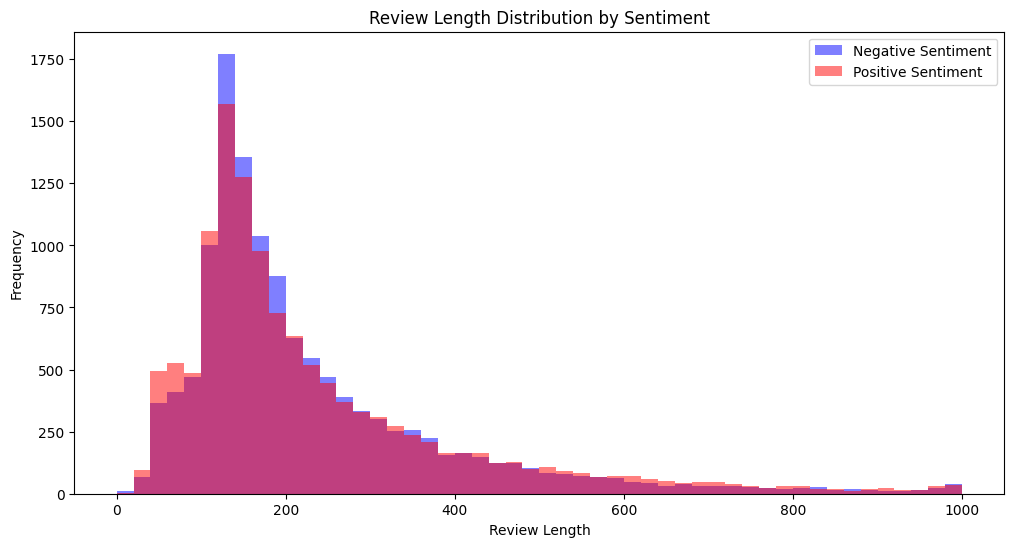

In [6]:
# Distribution of review length by sentiment (excluding reviews above 1,000 words)
train['review_length'] = train['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
train['review_length'][train['sentiment'] == 0].plot(kind='hist', bins=50, range=(0,1000), alpha=0.5, color='blue')
train['review_length'][train['sentiment'] == 1].plot(kind='hist', bins=50, range=(0,1000), alpha=0.5, color='red')
plt.legend(['Negative Sentiment', 'Positive Sentiment'])
plt.xlabel('Review Length')
plt.title('Review Length Distribution by Sentiment')
plt.show()

In [7]:
# Check review text format
wrapper = textwrap.TextWrapper(width=150)
print(wrapper.fill(train['review'][0]))

With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz
and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe
make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it
was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br
/><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this
and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for
the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally star

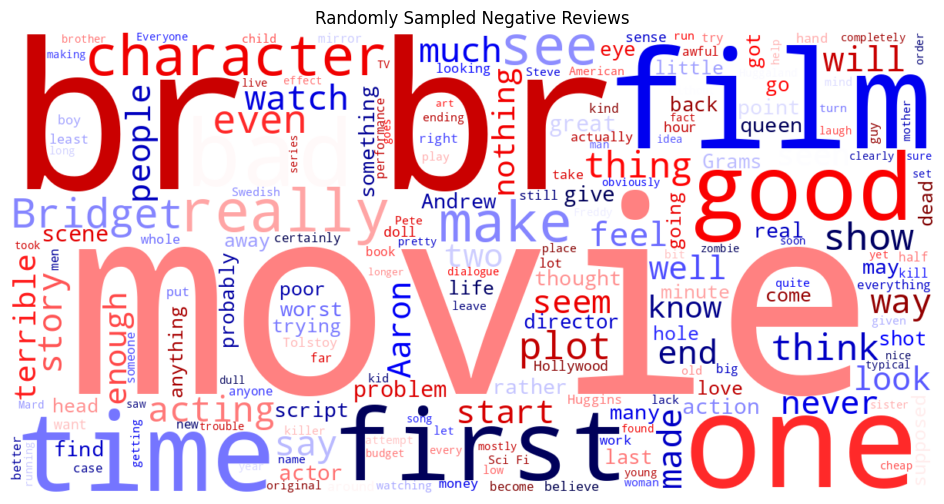

In [8]:
# Word cloud of 50 randomly selected negative reviews
np.random.seed(50)
negative_reviews = train[train['sentiment'] == 0].sample(50)
negative_words = ' '.join(negative_reviews['review'])
negative_wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='seismic').generate(negative_words)

plt.figure(figsize=(12,6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Randomly Sampled Negative Reviews')
plt.axis('off')
plt.show()

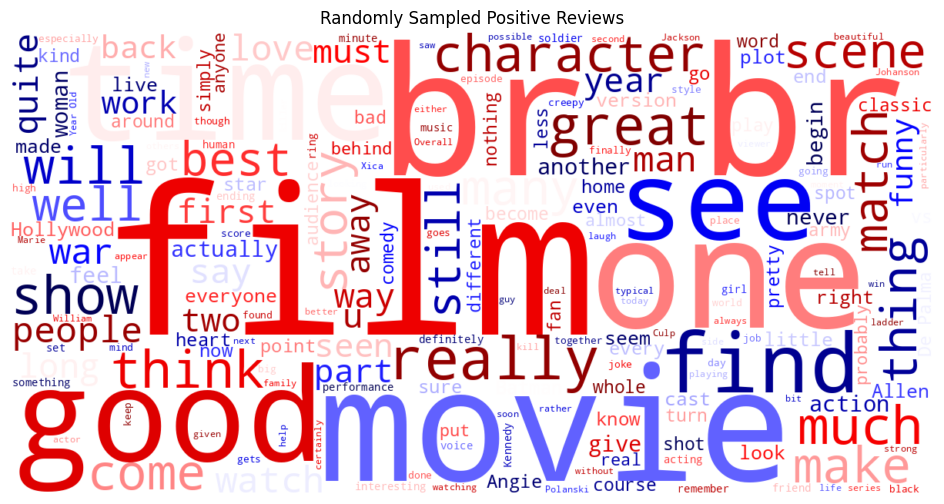

In [9]:
# Word cloud of 50 randomly selected positive reviews
np.random.seed(50)
positive_reviews = train[train['sentiment'] == 1].sample(50)
positive_words = ' '.join(positive_reviews['review'])
positive_wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='seismic').generate(positive_words)

plt.figure(figsize=(12,6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Randomly Sampled Positive Reviews')
plt.axis('off')
plt.show()

### Natural language processing

Based on my EDA above, it was clear to me that the reviews needed a lot of text processing to get ready for model building. One red flag from the wordcloud was the inclusion of "br", which indicated the presence of HTML line breaks in the multi-paragraph reviews. I made sure to include the removal of html code in my helper function to clean the text, alongside removing other special characters, punctuation, numbers, and single-letter words. I also included a lemmatizer to limit the number of unique words by combining similar words and returning verbs to their root form. I also remove stop words, or words frequently used that provide little or no benefit for context, such as "the". All of these adjustments result in clean and significantly shorter reviews, as shown in the histogram below. Then, I tokenized the clean reviews and padded/truncated them to a fixed length of 200 words. Finally, I used Stanford's GloVe 100 dimension word embeddings to create the embeddings matrix required for my neural networks' embedding layers.

In [10]:
# Helper function to clean text
def clean_text(text):
    # Lowercase all words
    text = text.lower()
    # Remove html
    text = re.sub('<.*?>', ' ', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove numbers
    text = re.sub('\d+', ' ', text)
    # Remove extra whitespace
    text = re.sub('\s+', ' ', text)
    # Remove single letter words
    text = ' '.join([word for word in text.split() if len(word) > 1])
    # Lemmatize words using NLTK's lemmatizer
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    text = ' '.join([lemmatizer.lemmatize(word, pos='v') for word in text.split()])
    # Remove stop words using NLTK's stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Return text
    return text

In [11]:
# Clean training and test reviews
train['clean_review'] = train['review'].apply(clean_text)
test['clean_review'] = test['review'].apply(clean_text)

In [12]:
# Compare original to clean review
print('Original Review:\n')
print(wrapper.fill(train['review'][0]))
print('\nClean Review:\n')
print(wrapper.fill(train['clean_review'][0]))

Original Review:

With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz
and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe
make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it
was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br
/><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this
and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for
the fans which if true is really nice of him.<br /><br />The actual feature film bit wh

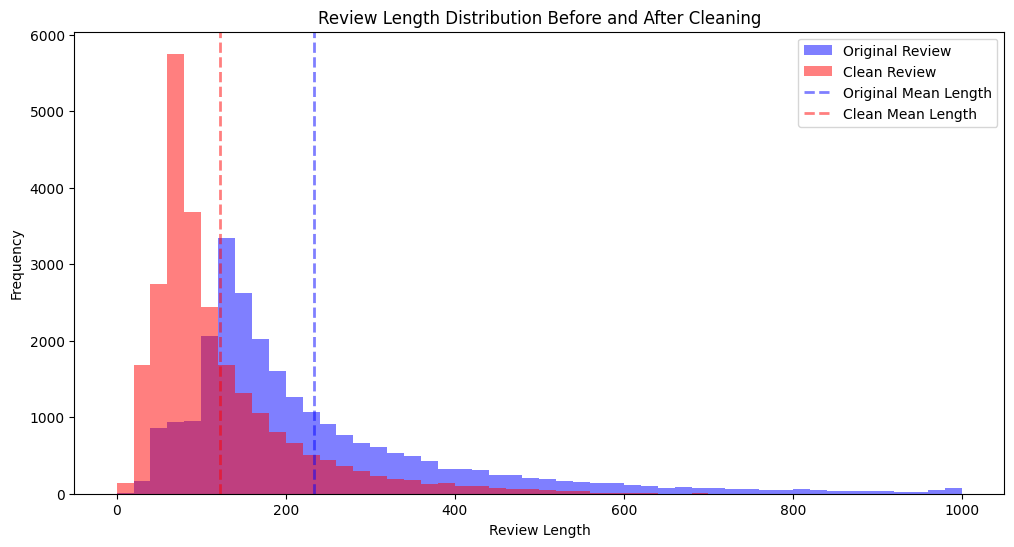

In [13]:
# Compare review length distribution before and after cleaning
train['clean_review_length'] = train['clean_review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
train['review_length'].plot(kind='hist', bins=50, range=(0,1000), alpha=0.5, color='blue')
train['clean_review_length'].plot(kind='hist', bins=50, range=(0,1000), alpha=0.5, color='red')
plt.axvline(train['review_length'].mean(), color='blue', linestyle='dashed', linewidth=2, alpha=0.5)
plt.axvline(train['clean_review_length'].mean(), color='red', linestyle='dashed', linewidth=2, alpha=0.5)
plt.legend(['Original Review', 'Clean Review', 'Original Mean Length', 'Clean Mean Length'])
plt.xlabel('Review Length')
plt.title('Review Length Distribution Before and After Cleaning')
plt.show()

In [14]:
# Tokenize reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['clean_review'])
train_token = tokenizer.texts_to_sequences(train['clean_review'])
test_token = tokenizer.texts_to_sequences(test['clean_review'])

# Pad reviews to fixed length
max_length = 200
train_pad = pad_sequences(train_token, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_token, maxlen=max_length, padding='post', truncating='post')

# Unique words in all reviews
len(tokenizer.word_index)

57541

In [15]:
# Create embeddings dictionary with GloVe
embeddings_dict = {}
glove_file = open('/kaggle/input/glove-6b-100d-txt/glove.6B.100d.txt', encoding='utf8')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector_dimensions
glove_file.close()

In [16]:
# Create embedding matrix with GloVe
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Recurrent Neural Network Model

### Model architecture

For this problem, I chose to use an RNN as my model of choice. Specifically, I chose to use a Bidirectional Long Short-Term Memory Network (Bi-LSTM) because of its usefulness for longer word sequences. The network can keep track of important words that occur earlier in a sequence in case they remain important for words later on, which can help greatly for similar problems in sentiment analysis where context is important. The bidirectional aspect allows the LSTM to operate forward and backward, which can also help improve performance from a strictly forward network. This architecture ends with a sigmoid activation function to convert the output into a 0 or 1 to predict a negative or positive sentiment about the movie, allowing the model to compare to the 'sentiment' target column in the training dataset.

In [17]:
# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(train_pad, train['sentiment'], test_size=0.2, random_state=50)

In [18]:
# Build initial BiLSTM model
model = Sequential()

# Add layers
model.add(Embedding(len(tokenizer.word_index)+1, 100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Initial model training

For my initial RNN model, I used 10 epochs with a batch size of 100 to improve efficiency. The model did train quickly and reached a final validation accuracy just shy 85% However, there is definitely room for improvement, especially because the model has signs of overfitting on the training data, which continued to increase while the validation accuracy leveled out.

In [19]:
# Train model
mod_results = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=100)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6382 - loss: 0.6279 - val_accuracy: 0.7604 - val_loss: 0.5088
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7806 - loss: 0.4785 - val_accuracy: 0.8056 - val_loss: 0.4377
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8160 - loss: 0.4194 - val_accuracy: 0.8154 - val_loss: 0.4408
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8258 - loss: 0.4029 - val_accuracy: 0.8084 - val_loss: 0.4301
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8441 - loss: 0.3672 - val_accuracy: 0.8346 - val_loss: 0.3847
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8531 - loss: 0.3480 - val_accuracy: 0.8452 - val_loss: 0.3715
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8670 - loss: 0.3178 - val_accuracy: 0.8444 - val_loss: 0.3662
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8771 - loss: 0.2976 - val_acc

In [20]:
# Show built model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (100, 200, 100)             │       5,754,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (100, 128)                  │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (100, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,008,029 (22.92 MB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 5,754,200 (21.95 MB)

 Optimizer params: 169,220 (661.02 KB)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


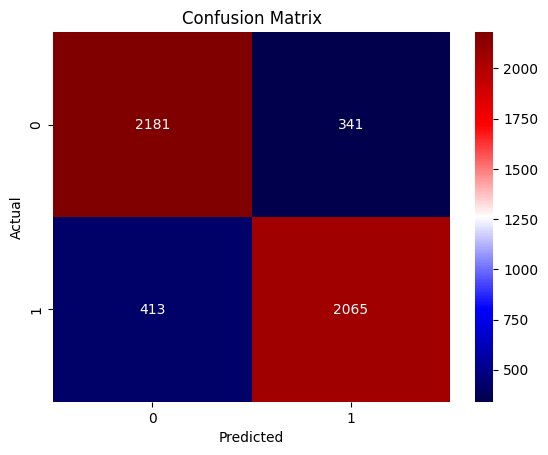

In [21]:
# Create confusion matrix and heatmap for validation data
y_pred = model.predict(X_val).round()
confusion = confusion_matrix(y_val, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='seismic')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

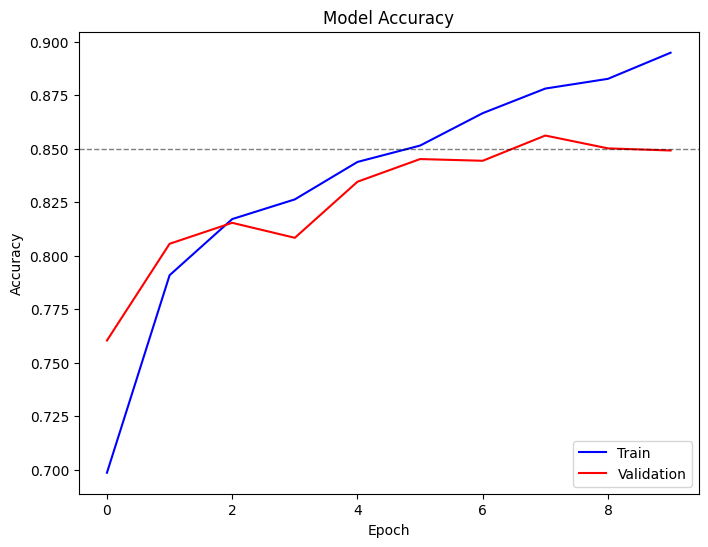

In [23]:
# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(mod_results.history['accuracy'], color='blue')
plt.plot(mod_results.history['val_accuracy'], color='red')
plt.axhline(0.85, color='black', linestyle='dashed', linewidth=1, alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()

## Results and Analysis

### Improving model performance

The initial model performed okay, but to combat the potential overfitting, I tried a few additional model architectures that included dropout layers. Adding the dropout layers, especially a recurrent dropout inside the Bi-LSTM, does slow down the model fitting process significantly, but it also successfully combats the overfitting problem from the original model while maintaining the validation accuracy. I also tried adding an additional Bi-LSTM layer to refine results further, but this slowed the model down significantly while also lowering the performance. Finally, I adjusted the RNN architecture one last time to incorporate a global max pooling layer, which did boost the model results even further to a validation accuracy of 86.3% without having a large impact on the model efficiency.

In [24]:
# Modify model architecture with additional layers
model2 = Sequential()

# Add layers
model2.add(Embedding(len(tokenizer.word_index)+1, 100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = optimizers.Adam(learning_rate=0.001)
model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [25]:
# Fit model
mod2_results = model2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=100)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 262ms/step - accuracy: 0.6183 - loss: 0.6457 - val_accuracy: 0.7046 - val_loss: 0.5828
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 258ms/step - accuracy: 0.7368 - loss: 0.5437 - val_accuracy: 0.7780 - val_loss: 0.4763
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 261ms/step - accuracy: 0.7644 - loss: 0.4961 - val_accuracy: 0.8146 - val_loss: 0.4129
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 255ms/step - accuracy: 0.7969 - loss: 0.4436 - val_accuracy: 0.8262 - val_loss: 0.4015
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 256ms/step - accuracy: 0.8131 - loss: 0.4141 - val_accuracy: 0.8044 - val_loss: 0.4206
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 256ms/step - accuracy: 0.8161 - loss: 0.4089 - val_accuracy: 0.8372 - val_loss: 0.3693
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 256ms/step - accuracy: 0.8333 - loss: 0.3787 - val_accuracy: 0.8384 - val_loss: 0.3693
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 258ms/step - accuracy: 0.8371 - loss: 0

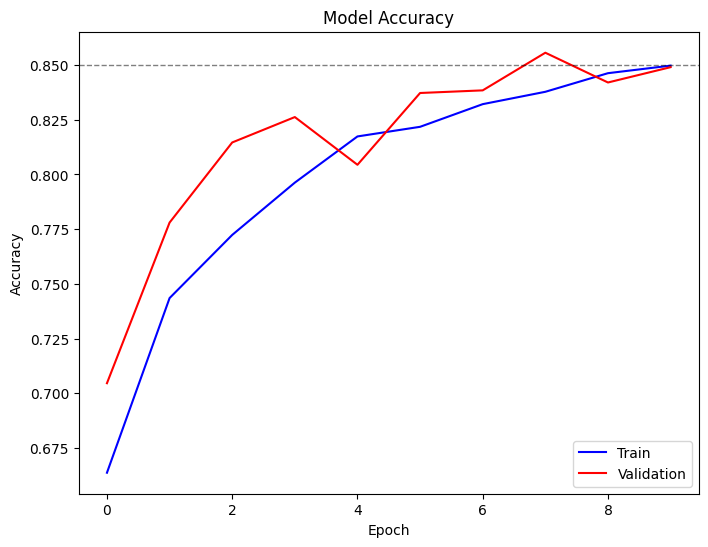

In [27]:
# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(mod2_results.history['accuracy'], color='blue')
plt.plot(mod2_results.history['val_accuracy'], color='red')
plt.axhline(0.85, color='black', linestyle='dashed', linewidth=1, alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()

In [28]:
# Modify model architecture with additional layers
model3 = Sequential()

# Add layers
model3.add(Embedding(len(tokenizer.word_index)+1, 100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model3.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model3.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = optimizers.Adam(learning_rate=0.001)
model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [29]:
# Fit model
mod3_results = model3.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=100)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 666ms/step - accuracy: 0.6043 - loss: 0.6494 - val_accuracy: 0.7020 - val_loss: 0.5647
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 657ms/step - accuracy: 0.7269 - loss: 0.5502 - val_accuracy: 0.7928 - val_loss: 0.4573
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 662ms/step - accuracy: 0.7540 - loss: 0.5148 - val_accuracy: 0.8136 - val_loss: 0.4292
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 662ms/step - accuracy: 0.7731 - loss: 0.4850 - val_accuracy: 0.8142 - val_loss: 0.4463
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 660ms/step - accuracy: 0.7897 - loss: 0.4596 - val_accuracy: 0.8050 - val_loss: 0.4378


In [30]:
# Modify model architecture with additional layers
model4 = Sequential()

# Add layers
model4.add(Embedding(len(tokenizer.word_index)+1, 100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model4.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model4.add(GlobalMaxPool1D())
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = optimizers.Adam(learning_rate=0.001)
model4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [31]:
# Fit model
mod4_results = model4.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=100)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 311ms/step - accuracy: 0.6447 - loss: 0.6118 - val_accuracy: 0.8094 - val_loss: 0.4232
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 308ms/step - accuracy: 0.8041 - loss: 0.4262 - val_accuracy: 0.8364 - val_loss: 0.3714
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - accuracy: 0.8341 - loss: 0.3761 - val_accuracy: 0.8442 - val_loss: 0.3496
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 308ms/step - accuracy: 0.8503 - loss: 0.3428 - val_accuracy: 0.8518 - val_loss: 0.3385
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - accuracy: 0.8642 - loss: 0.3151 - val_accuracy: 0.8550 - val_loss: 0.3316
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - accuracy: 0.8693 - loss: 0.3068 - val_accuracy: 0.8542 - val_loss: 0.3349
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 310ms/step - accuracy: 0.8784 - loss: 0.2926 - val_accuracy: 0.8534 - val_loss: 0.3369
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - accuracy: 0.8819 - loss: 0

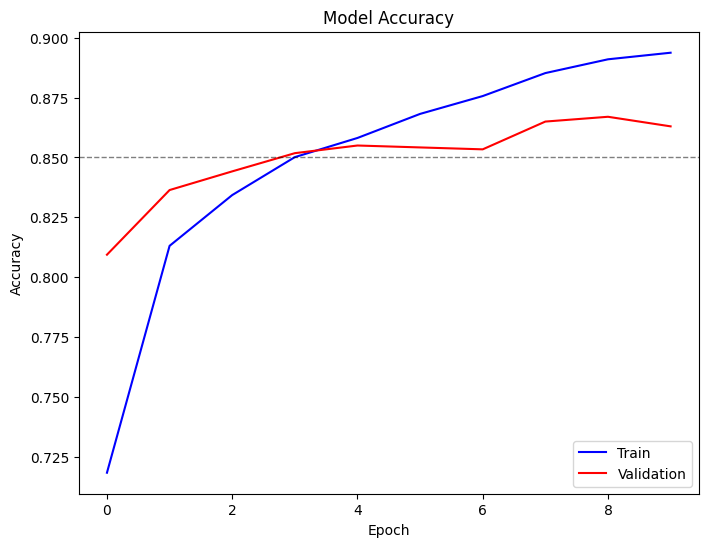

In [33]:
# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(mod4_results.history['accuracy'], color='blue')
plt.plot(mod4_results.history['val_accuracy'], color='red')
plt.axhline(0.85, color='black', linestyle='dashed', linewidth=1, alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()

### Increasing max review length

Because none of the hyperparameter tuning or layer structure adjustments were really helping the performance of my model, I decided to go backward a few steps and see how adjusting the max length of the reviews would affect the results. I doubled the length from 200 words to 400 words, which did affect the efficiency of the model because of the larger matrix size. However, I thought this reduction in efficiency might be a good tradeoff if the model performance increased significantly, since the new size would allow almost all movie reviews to have their full text included. I used the same model architecture from my highest performing model above with the new dataset. As I expected, the training time per epoch did double from an average of 62s to an average of 124s, but the model performance did increase to a validation accuracy of 87.5%.

In [34]:
# Pad reviews to fixed length - double the original
max_length = 400
train_pad2 = pad_sequences(train_token, maxlen=max_length, padding='post', truncating='post')
test_pad2 = pad_sequences(test_token, maxlen=max_length, padding='post', truncating='post')

# Split into new training and validation
X_train2, X_val2, y_train2, y_val2 = train_test_split(train_pad2, train['sentiment'], test_size=0.2, random_state=50)

In [35]:
#Same model architecture as model 4 but with longer review length
model5 = Sequential()

# Add layers
model5.add(Embedding(len(tokenizer.word_index)+1, 100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model5.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model5.add(GlobalMaxPool1D())
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = optimizers.Adam(learning_rate=0.001)
model5.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [36]:
# Fit model
mod5_results = model5.fit(X_train2, y_train2, epochs=10, validation_data=(X_val2, y_val2), batch_size=100)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 627ms/step - accuracy: 0.6441 - loss: 0.6117 - val_accuracy: 0.7888 - val_loss: 0.4458
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 622ms/step - accuracy: 0.8134 - loss: 0.4238 - val_accuracy: 0.8122 - val_loss: 0.4050
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 619ms/step - accuracy: 0.8356 - loss: 0.3720 - val_accuracy: 0.8458 - val_loss: 0.3536
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 623ms/step - accuracy: 0.8519 - loss: 0.3461 - val_accuracy: 0.8536 - val_loss: 0.3394
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 618ms/step - accuracy: 0.8624 - loss: 0.3232 - val_accuracy: 0.8640 - val_loss: 0.3215
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 619ms/step - accuracy: 0.8659 - loss: 0.3124 - val_accuracy: 0.8610 - val_loss: 0.3183
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 619ms/step - accuracy: 0.8773 - loss: 0.2929 - val_accuracy: 0.8700 - val_loss: 0.3105
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 123s 616ms/step - accuracy: 0.8853 -

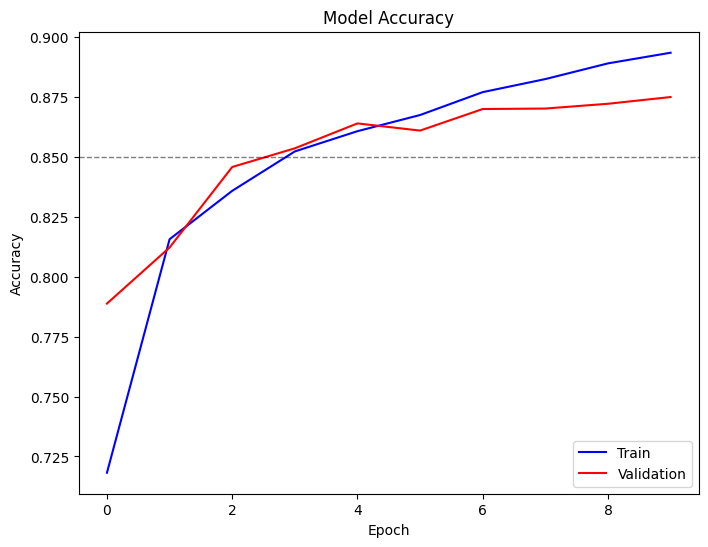

In [38]:
# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(mod5_results.history['accuracy'], color='blue')
plt.plot(mod5_results.history['val_accuracy'], color='red')
plt.axhline(0.85, color='black', linestyle='dashed', linewidth=1, alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()

In [45]:
model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (100, 400, 100)             │       5,754,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (100, 400, 128)             │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (100, 128)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (100, 64)                   │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (100, 64)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (100, 1)                    │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,032,605 (23.01 MB)

 Trainable params: 92,801 (362.50 KB)

 Non-trainable params: 5,754,200 (21.95 MB)

 Optimizer params: 185,604 (725.02 KB)

157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step


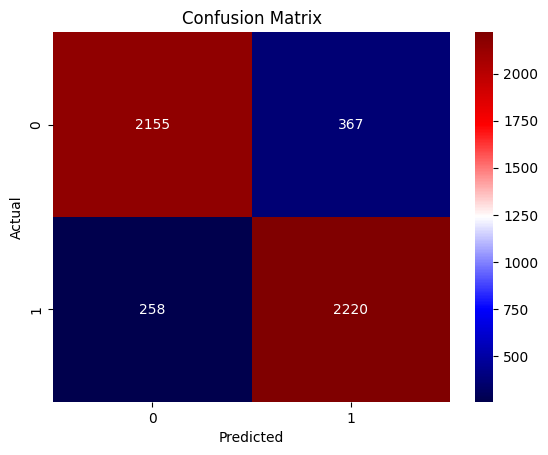

In [47]:
# Create confusion matrix and heatmap for validation data
y_pred5 = model5.predict(X_val2).round()
confusion = confusion_matrix(y_val2, y_pred5)
sns.heatmap(confusion, annot=True, fmt='d', cmap='seismic')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Limit the number of words in the tokenizer

One of the other things in the NLP stage that I wanted to experiment with was the number of words to include in the tokenizer. While keeping all the words in doesn't seem to affect the efficiency of the model, I thought that there could be a clutter of unique words only included in a few reviews, such as character names or words specific to a movie's plot, rather than more frequent words that could actual reflect the review author's sentiment. So, I decided to limit the number of words to 10,000 and then use the model architecture from above to see how this change impacts performance. To my surprise, this model actually performed almost identically to model 4 both in efficiency and in validation accuracy.

In [39]:
# Adjust the number of features in the tokenizer
max_features = 10000
tokenizer3 = Tokenizer(num_words=max_features)
tokenizer3.fit_on_texts(train['clean_review'])
train_token3 = tokenizer3.texts_to_sequences(train['clean_review'])
test_token3 = tokenizer3.texts_to_sequences(test['clean_review'])

# Pad reviews to fixed length
max_length = 200
train_pad3 = pad_sequences(train_token3, maxlen=max_length, padding='post', truncating='post')
test_pad3 = pad_sequences(test_token3, maxlen=max_length, padding='post', truncating='post')

# Split into new training and validation
X_train3, X_val3, y_train3, y_val3 = train_test_split(train_pad3, train['sentiment'], test_size=0.2, random_state=50)

In [40]:
# Create new embedding matrix with GloVe
embedding_matrix3 = np.zeros((len(tokenizer3.word_index)+1, 100))
for word, index in tokenizer3.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix3[index] = embedding_vector

In [41]:
# Same architecture as model 4 with different encoding data
model6 = Sequential()

# Add layers
model6.add(Embedding(len(tokenizer3.word_index)+1, 100, embeddings_initializer=Constant(embedding_matrix3), trainable=False))
model6.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model6.add(GlobalMaxPool1D())
model6.add(Dense(64, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = optimizers.Adam(learning_rate=0.001)
model6.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [42]:
# Fit model
mod6_results = model6.fit(X_train3, y_train3, epochs=10, validation_data=(X_val3, y_val3), batch_size=100)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 311ms/step - accuracy: 0.6512 - loss: 0.6088 - val_accuracy: 0.7938 - val_loss: 0.4440
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - accuracy: 0.8010 - loss: 0.4368 - val_accuracy: 0.8324 - val_loss: 0.3832
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 308ms/step - accuracy: 0.8240 - loss: 0.3887 - val_accuracy: 0.8422 - val_loss: 0.3612
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 305ms/step - accuracy: 0.8417 - loss: 0.3605 - val_accuracy: 0.8504 - val_loss: 0.3403
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - accuracy: 0.8591 - loss: 0.3313 - val_accuracy: 0.8522 - val_loss: 0.3356
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 308ms/step - accuracy: 0.8681 - loss: 0.3149 - val_accuracy: 0.8568 - val_loss: 0.3280
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 309ms/step - accuracy: 0.8778 - loss: 0.2960 - val_accuracy: 0.8608 - val_loss: 0.3245
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 308ms/step - accuracy: 0.8872 - loss: 0

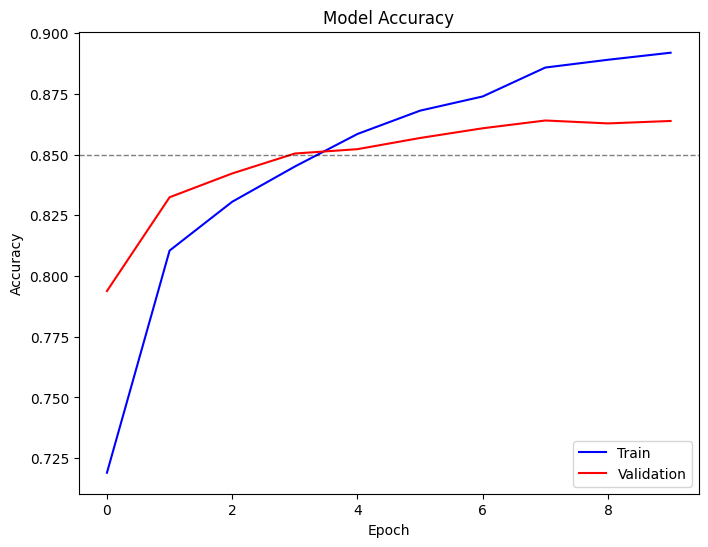

In [44]:
# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(mod6_results.history['accuracy'], color='blue')
plt.plot(mod6_results.history['val_accuracy'], color='red')
plt.axhline(0.85, color='black', linestyle='dashed', linewidth=1, alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()

## Conclusion

Overall, I believe that this project was an in-depth exploration of NLP and RNNs to achieve real-world goals through sentiment analysis. It was also interesting to see which parameters and model architectures helped performance versus some other tuning that kept performance the same while just increasing or decreasing the model efficiency. My best performing model was model 5 which ended up with a training accuracy of 89.9% and a validation accuracy of 87.5%. Based on the fact that most of my hyperparameter tuning, architecture adjustments, doubling the review length, and changing the embedding size failed to increase the model's validation accuracy past 87.5%, an RNN might not be the best choice for this particular prediction problem. For future improvements, I think it would be interesting to try other encoding methods with different word embeddings beyond GloVe. Additionally, it could be the case that another deep learning or broader supervised learning method might work better for this dataset, so future steps could also include exploring other techniques to improve model performance.

## References

[1] Wendy Kan, Will Cukierski, and joycenv. Kaggle. "Bag of Words Meets Bags of Popcorn." https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview

[2] Daniel Will George. Kaggle. "glove.6B.100d.txt: Standofr's GLOVE 100d Word Embeddings." https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt

[3] Keras. "Using Pre-trained Word Embeddings." May 5, 2020. https://keras.io/examples/nlp/pretrained_word_embeddings/

[4] Anishnama. Medium. "Understanding Bidirectional LSTM for Sequential Data Processing." May 18, 2023. https://medium.com/@anishnama20/understanding-bidirectional-lstm-for-sequential-data-processing-b83d6283befc